# Bayesian Neural Networks

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [5]:
cluster_candidates = pd.read_csv('../PleiadesTidalTails/data/clean.csv')

scaler_astrometry = StandardScaler()
scaler_rv = StandardScaler()

cluster_candidates[['ra','dec','pmra','pmdec','parallax']] = scaler_astrometry.fit_transform(cluster_candidates[['ra','dec','pmra','pmdec','parallax']])
#cluster_candidates[['l','b','pmra','pmdec','parallax']] = scaler_astrometry.fit_transform(cluster_candidates[['l','b','pmra','pmdec','parallax']])
#cluster_candidates[['radial_velocity','radial_velocity_error']] = scaler_rv.fit_transform(cluster_candidates[['radial_velocity','radial_velocity_error']])
cluster_candidates[['radial_velocity']] = scaler_rv.fit_transform(cluster_candidates[['radial_velocity']])
del cluster_candidates['Unnamed: 0']

print(len(cluster_candidates))

cluster_candidates_rv = cluster_candidates[~cluster_candidates['radial_velocity'].isna()]
#cluster_candidates_rv = cluster_candidates_rv[~cluster_candidates_rv['radial_velocity_error'].isna()]
print(len(cluster_candidates_rv))
cluster_candidates_rv = cluster_candidates_rv[(np.abs(cluster_candidates_rv['radial_velocity']) <= 0.25*np.std(cluster_candidates_rv['radial_velocity']))]
cluster_candidates_rv.info()

1502
509
<class 'pandas.core.frame.DataFrame'>
Index: 384 entries, 0 to 1488
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   level_0                     384 non-null    int64  
 1   index                       384 non-null    int64  
 2   source_id                   384 non-null    int64  
 3   ra                          384 non-null    float64
 4   ra_error                    384 non-null    float64
 5   dec                         384 non-null    float64
 6   dec_error                   384 non-null    float64
 7   l                           384 non-null    float64
 8   b                           384 non-null    float64
 9   parallax                    384 non-null    float64
 10  parallax_error              384 non-null    float64
 11  pmra                        384 non-null    float64
 12  pmra_error                  384 non-null    float64
 13  pmdec                       38

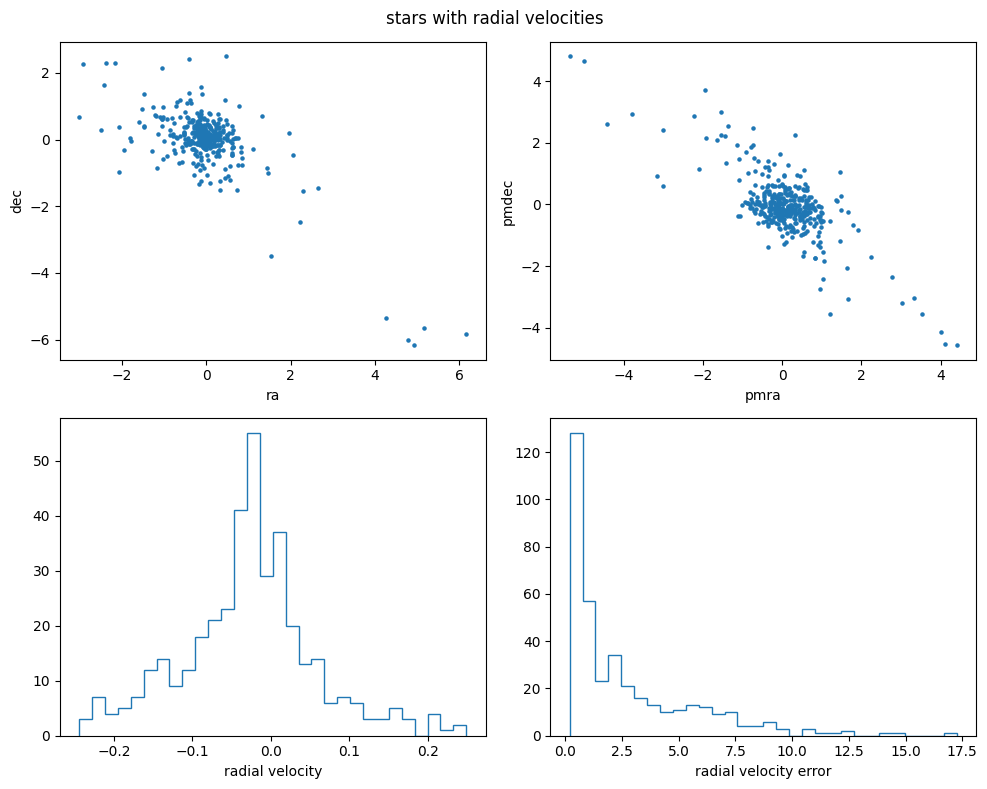

In [6]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

fig.suptitle('stars with radial velocities')

ax[0,0].scatter(cluster_candidates_rv['ra'], cluster_candidates_rv['dec'], s=5)
ax[0,0].set_xlabel('ra')
ax[0,0].set_ylabel('dec')

ax[0,1].scatter(cluster_candidates_rv['pmra'], cluster_candidates_rv['pmdec'], s=5)
ax[0,1].set_xlabel('pmra')
ax[0,1].set_ylabel('pmdec')

ax[1,0].hist(cluster_candidates_rv['radial_velocity'], bins=30, density=False, histtype='step')
ax[1,0].set_xlabel('radial velocity')

ax[1,1].hist(cluster_candidates_rv['radial_velocity_error'], bins=30, histtype='step', density=False)
ax[1,1].set_xlabel('radial velocity error')
fig.tight_layout()
plt.show()

In [7]:
x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec','parallax']])
#x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec']])
#x_data = np.array(cluster_candidates_rv[['l','b','pmra','pmdec','parallax']])

#y_data = np.array(cluster_candidates_rv[['radial_velocity','radial_velocity_error']])
y_data = np.array(cluster_candidates_rv[['radial_velocity']])
x_data.shape, y_data.shape

((384, 5), (384, 1))

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=42)

print('Training shape:', x_train.shape, y_train.shape)
print('Testing shape:', x_test.shape, y_test.shape)

Training shape: (230, 5) (230, 1)
Testing shape: (154, 5) (154, 1)


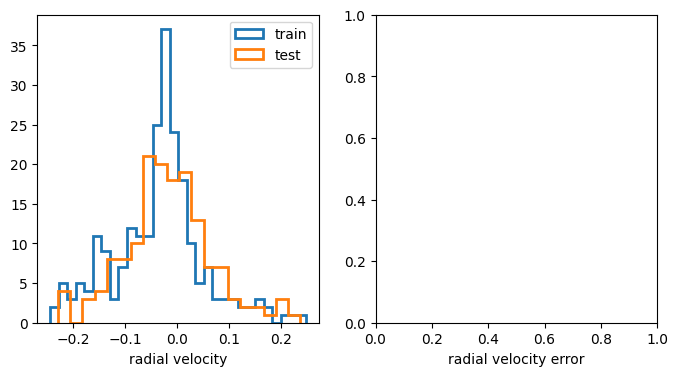

In [9]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist(y_train[:,0], bins=30, density=False, histtype='step', label='train', lw=2)
plt.hist(y_test[:,0], bins=20, density=False, histtype='step', label='test', lw=2)
plt.legend()
plt.xlabel('radial velocity')

plt.subplot(1,2,2)
# plt.hist(y_train[:,1], bins=30, density=False, histtype='step', label='train')
# plt.hist(y_test[:,1], bins=20, density=False, histtype='step', label='test')
# plt.legend()
plt.xlabel('radial velocity error')
plt.show()

In [10]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=5, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.ReLU()  # nn.Tanh()  # or nn.ReLU() nn.LeakyReLU() 
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        #x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [11]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

In [12]:
# Convert data to PyTorch tensors
x_train_ = torch.from_numpy(x_train).float()
y_train_ = torch.from_numpy(y_train).float()

x_test_ = torch.from_numpy(x_test).float()
y_test_ = torch.from_numpy(y_test).float()

print('Train:', x_train_.shape, y_train_.shape)
print('Test:', x_test_.shape, y_test_.shape)

Train: torch.Size([230, 5]) torch.Size([230, 1])
Test: torch.Size([154, 5]) torch.Size([154, 1])


In [13]:
# Run MCMC
mcmc.run(x_train_, y_train_)

Warmup:   0%|          | 0/100 [00:00, ?it/s]/home/steven/.local/lib/python3.8/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 100/100 [01:34,  1.06it/s, step size=7.25e-04, acc. prob=0.467]


In [14]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
#x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds_train = predictive(x_train_)
preds_test = predictive(x_test_)

prediction_train = preds_train['obs'].T.detach().numpy().mean(axis=1)
prediction_test = preds_test['obs'].T.detach().numpy().mean(axis=1)

prediction_train.shape, prediction_test.shape

((230,), (154,))

# Plot predictions and compare

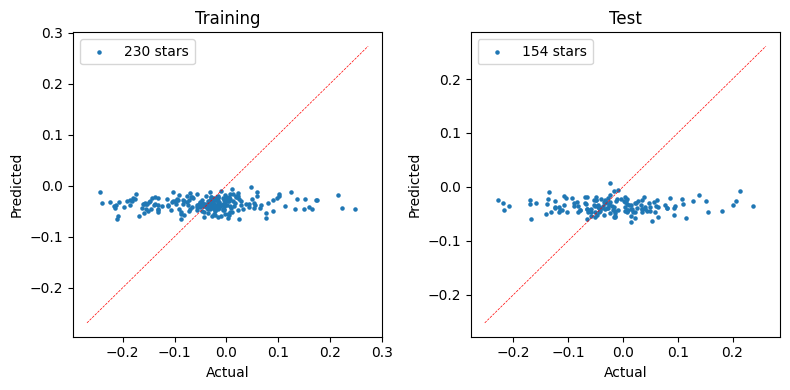

Train: 0.06405792235057978
Test: 0.06569750505681826


In [15]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

axes[0].scatter(y_train, prediction_train, s=5, label='%s stars'%len(y_train))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red', ls='--', lw=0.5)
axes[0].legend()

axes[1].scatter(y_test, prediction_test, s=5, label='%s stars'%len(y_test))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red', ls='--', lw=0.5)
axes[1].legend()

fig.tight_layout()
plt.show()

print('Train:',mean_absolute_error(y_train, prediction_train)) # train
print('Test:',mean_absolute_error(y_test, prediction_test)) # test

# Deep Bayesian Neural Network

In [23]:
class BNN(PyroModule):
    def __init__(self, in_dim=5, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.ReLU()  # could also be ReLU or LeakyReLU or Tanh
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        #x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [24]:
x_train_.shape, y_train_.shape

(torch.Size([230, 5]), torch.Size([230, 1]))

In [25]:
# define model and data
model = BNN(hid_dim=10, n_hid_layers=10, prior_scale=5.)

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=True)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(x_train_, y_train_)

Warmup:   0%|          | 0/100 [00:00, ?it/s]/home/steven/.local/lib/python3.8/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 100/100 [07:25,  4.45s/it, step size=2.57e-09, acc. prob=0.920]


In [26]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds_train = predictive(x_train_)
preds_test = predictive(x_test_)

prediction_train = preds_train['obs'].T.detach().numpy().mean(axis=1)
prediction_test = preds_test['obs'].T.detach().numpy().mean(axis=1)

prediction_train.shape, prediction_test.shape

((230,), (154,))

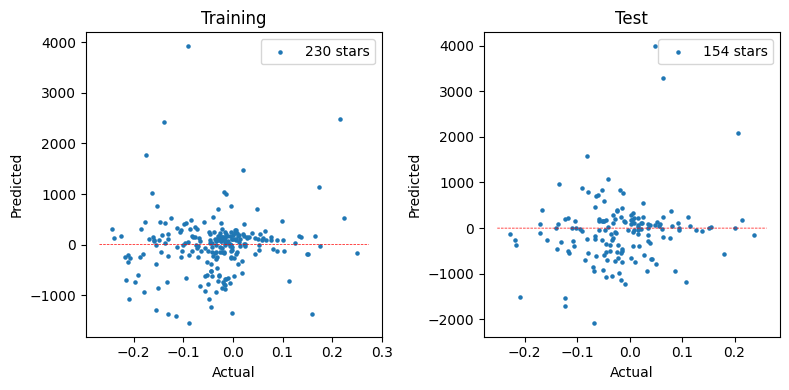

Train: 366.5355565702729
Test: 449.0459402245272


In [27]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

axes[0].scatter(y_train, prediction_train, s=5, label='%s stars'%len(y_train))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red', ls='--', lw=0.5)
axes[0].legend()

axes[1].scatter(y_test, prediction_test, s=5, label='%s stars'%len(y_test))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red', ls='--', lw=0.5)
axes[1].legend()

fig.tight_layout()
plt.show()

print('Train:',mean_absolute_error(y_train, prediction_train)) # train
print('Test:',mean_absolute_error(y_test, prediction_test)) # test

# Train BNNs with mean-field variational inference

In [63]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train_, y_train_.squeeze())
    progress_bar.set_postfix(loss=f"{loss / x_train_.shape[0]:.3f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

In [64]:
predictive = Predictive(model=model, guide=mean_field_guide, num_samples=500)
preds_train = predictive(x_train_)
preds_test = predictive(x_test_)

prediction_train = preds_train['obs'].T.detach().numpy().mean(axis=1)
prediction_test = preds_test['obs'].T.detach().numpy().mean(axis=1)

prediction_train.shape, prediction_test.shape

((218,), (146,))

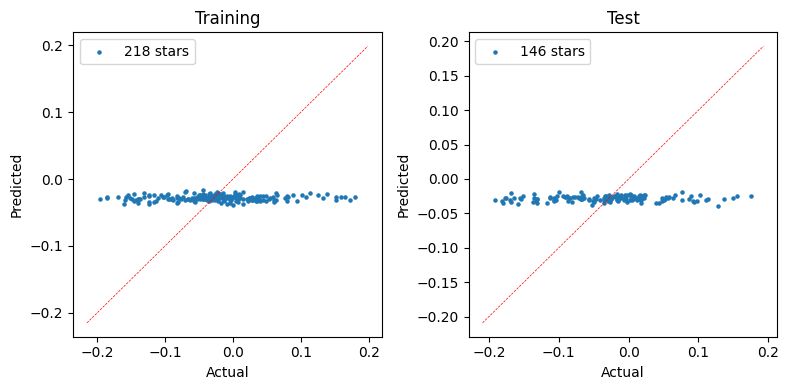

Train: 0.051648857425986086
Test: 0.060360004841492065


In [65]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

axes[0].scatter(y_train, prediction_train, s=5, label='%s stars'%len(y_train))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red', ls='--', lw=0.5)
axes[0].legend()

axes[1].scatter(y_test, prediction_test, s=5, label='%s stars'%len(y_test))
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red', ls='--', lw=0.5)
axes[1].legend()

fig.tight_layout()
plt.show()

print('Train:',mean_absolute_error(y_train, prediction_train)) # train
print('Test:',mean_absolute_error(y_test, prediction_test)) # test